<a href="https://colab.research.google.com/github/aiscience-22/UA_War/blob/olgap%2Fmachine_learning_0.06/deep_learning_negative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installs latest version of TensorFlow 2.X 
# !pip install --upgrade tensorflow

In [ ]:
# Import our dependencies
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import datetime
from datetime import datetime
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn as skl
import tensorflow as tf

In [ ]:
# Find the latest version of spark 3.0 from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.2.2'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Ign:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:13 http://security.ubuntu.c

In [ ]:
# Add drivers to Spark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CloudETL").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

In [ ]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url ="https://aiscience22.s3.us-west-1.amazonaws.com/joined.csv"

spark.sparkContext.addFile(url)
text_df = spark.read.csv(SparkFiles.get("joined.csv"), sep=",", header=True, inferSchema=True)


# Show DataFrame
text_df.show()

+-------------+---------+---------+-----------+-------------+--------------+------------+--------------------+--------+--------------+-----------+----------+---------------+----------+--------------------+-----------+-----------+-----------+--------------+----------+
|     username|following|followers|totaltweets|usercreatedts|tweetcreatedts|retweetcount|            hashtags|language|favorite_count|extractedts|is_retweet|is_quote_status|weekofyear|        cleaned_text|   negative|    neutral|   positive|search_results|    weight|
+-------------+---------+---------+-----------+-------------+--------------+------------+--------------------+--------+--------------+-----------+----------+---------------+----------+--------------------+-----------+-----------+-----------+--------------+----------+
|     Theo1001|      312|      123|      38156|   2008-05-14|    2022-04-22|          67|[{''text'': ''Sta...|      en|             0| 2022-04-22|      true|          false|        16|thank you si

# Exploring the taken data

In [ ]:
# Convert DataFrame to Pandas
joined_data_df = text_df.toPandas()
print(joined_data_df.shape)
joined_data_df.head(5)

(451700, 20)


,username,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,hashtags,language,favorite_count,extractedts,is_retweet,is_quote_status,weekofyear,cleaned_text,negative,neutral,positive,search_results,weight
0,Theo1001,312,123,38156,2008-05-14,2022-04-22,67,"[{''text'': ''StandWithUkraine'', ''indices'':...",en,0,2022-04-22,True,False,16,thank you sir we will not forget those who con...,0.010234,0.719316,0.270449,196000.0,0.000985
1,ereguly,4787,9149,22818,2008-12-31,2022-04-24,3,"[{''text'': ''LePen'', ''indices'': [28, 34]},...",en,5,2022-04-24,False,True,16,of course pas de surprise tainted by her close...,0.004823,0.675433,0.319744,94500.0,0.000475
2,davidgodfrey,5003,464,44931,2008-10-12,2022-04-24,97,"[{''text'': ''Mariupol'', ''indices'': [36, 45]}]",en,0,2022-04-24,True,False,16,no corridors from again russians did not allow...,0.018234,0.883309,0.098457,94500.0,0.000475
3,cazacioc,1712,1019,38691,2008-12-06,2022-04-24,500,"[{''text'': ''SlavaUkraini'', ''indices'': [30...",en,0,2022-04-24,True,False,16,thank you,0.169791,0.608387,0.221821,94500.0,0.000475
4,Daily_Express,761,935851,1066678,2008-12-05,2022-04-22,0,"[{''text'': ''Ukraine'', ''indices'': [63, 71]}]",en,2,2022-04-22,False,False,16,president biden unveils m worth of military as...,0.156944,0.766128,0.076928,196000.0,0.000985


In [ ]:
# Change the dtypes of tweetcreatedts
joined_data_df["tweetcreatedts"] = pd.to_datetime(joined_data_df["tweetcreatedts"]).dt.date
print (joined_data_df["tweetcreatedts"])

0         2022-04-22
1         2022-04-24
2         2022-04-24
3         2022-04-24
4         2022-04-22
             ...    
451695    2022-07-31
451696    2022-07-31
451697    2022-07-31
451698    2022-07-31
451699    2022-07-31
Name: tweetcreatedts, Length: 451700, dtype: object


# Explore the data if nothing lost

In [ ]:
earliest_tweet = joined_data_df["tweetcreatedts"].min()
latest_tweet = joined_data_df["tweetcreatedts"].max()

print(f"The earliest tweet was at {earliest_tweet}, and the latest was at {latest_tweet}")

The earliest tweet was at 2022-04-22, and the latest was at 2022-08-18


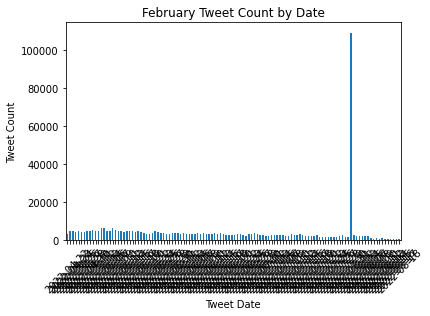

In [ ]:
from pandas.core.arrays.datetimelike import DatetimeLikeScalar
from numpy.core.multiarray import datetime_as_string
#Get the plot of tweet count by date 
dates = joined_data_df["tweetcreatedts"]

# group tweet timestamps by date and get tweet count for each date
tweetcount_by_date = joined_data_df["tweetcreatedts"].groupby(dates).size()

# plot bar graph of tweet count by date
tweetcount_by_date.plot.bar();

plt.title("February Tweet Count by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Tweet Count")
plt.xticks(rotation=45)
plt.show()

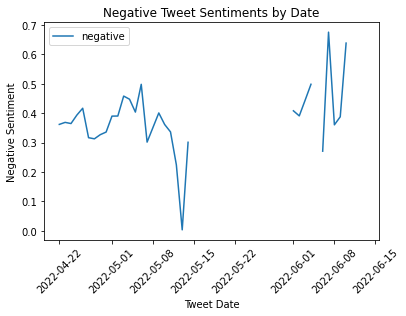

In [ ]:
#Get the plot of negative score by date of tweet
negative_df = joined_data_df[['tweetcreatedts', 'negative']]

negative_by_date = negative_df.groupby([negative_df['tweetcreatedts']]).mean()

# plot bar graph of tweet count by date
negative_by_date.plot.line();

plt.title("Negative Tweet Sentiments by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Negative Sentiment")
plt.xticks(rotation=45)
plt.show()


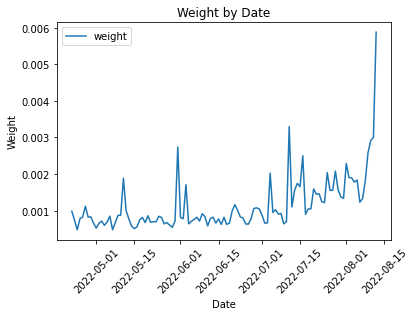

In [ ]:
#Get the plot of day weight by date
joined_data_df.plot.line(x='tweetcreatedts', y='weight');

plt.title("Weight by Date")
plt.xlabel("Date")
plt.ylabel("Weight")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# Cleaning data

In [ ]:
# Drop the not needed column
joined_data_df.drop("username", axis=1, inplace=True)
joined_data_df.drop("usercreatedts", axis=1, inplace=True)
joined_data_df.drop("language", axis=1, inplace=True)
joined_data_df.drop("favorite_count", axis=1, inplace=True)
joined_data_df.drop("extractedts", axis=1, inplace=True)
joined_data_df.drop("weekofyear", axis=1, inplace=True)
joined_data_df.drop("neutral", axis=1, inplace=True)
joined_data_df.drop("positive", axis=1, inplace=True)
joined_data_df.drop("search_results", axis=1, inplace=True)
joined_data_df.drop("retweetcount", axis=1, inplace=True)


In [ ]:
# Check data types
joined_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451700 entries, 0 to 451699
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   following        451700 non-null  int32  
 1   followers        451700 non-null  int32  
 2   totaltweets      451700 non-null  int32  
 3   tweetcreatedts   451700 non-null  object 
 4   hashtags         451700 non-null  object 
 5   is_retweet       451700 non-null  bool   
 6   is_quote_status  451700 non-null  bool   
 7   cleaned_text     451680 non-null  object 
 8   negative         83148 non-null   float64
 9   weight           449058 non-null  float64
dtypes: bool(2), float64(2), int32(3), object(3)
memory usage: 23.3+ MB


# Categorical valuables

In [ ]:
# Convert datetime to float

# time_df["tweetcreatedts"] = pd.to_numeric(joined_data_df.index, downcast='float')

joined_data_df['tweetcreatedts'] = joined_data_df['tweetcreatedts'].astype(str)
joined_data_df['tweetcreatedts'] = joined_data_df['tweetcreatedts'].str.replace('-', '')
joined_data_df['tweetcreatedts'] = joined_data_df['tweetcreatedts'].astype(float)
print(joined_data_df["tweetcreatedts"])

0         20220422.0
1         20220424.0
2         20220424.0
3         20220424.0
4         20220422.0
             ...    
451695    20220731.0
451696    20220731.0
451697    20220731.0
451698    20220731.0
451699    20220731.0
Name: tweetcreatedts, Length: 451700, dtype: float64


In [ ]:
# convert text to text lenght and drop the text
joined_data_df['text_length']  = joined_data_df['cleaned_text'].str.len()
joined_data_df.drop("cleaned_text", axis=1, inplace=True)

In [ ]:
# Replace boolean columns
joined_data_df['is_retweet'] = joined_data_df['is_retweet'].astype(int)
joined_data_df['is_quote_status'] = joined_data_df['is_quote_status'].astype(int)
joined_data_df.head()

,following,followers,totaltweets,tweetcreatedts,hashtags,is_retweet,is_quote_status,negative,weight,text_length
0,312,123,38156,20220422.0,"[{''text'': ''StandWithUkraine'', ''indices'':...",1,0,0.010234,0.000985,80.0
1,4787,9149,22818,20220424.0,"[{''text'': ''LePen'', ''indices'': [28, 34]},...",0,1,0.004823,0.000475,70.0
2,5003,464,44931,20220424.0,"[{''text'': ''Mariupol'', ''indices'': [36, 45]}]",1,0,0.018234,0.000475,123.0
3,1712,1019,38691,20220424.0,"[{''text'': ''SlavaUkraini'', ''indices'': [30...",1,0,0.169791,0.000475,9.0
4,761,935851,1066678,20220422.0,"[{''text'': ''Ukraine'', ''indices'': [63, 71]}]",0,0,0.156944,0.000985,59.0


In [ ]:
# Check data types
joined_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451700 entries, 0 to 451699
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   following        451700 non-null  int32  
 1   followers        451700 non-null  int32  
 2   totaltweets      451700 non-null  int32  
 3   tweetcreatedts   451700 non-null  float64
 4   hashtags         451700 non-null  object 
 5   is_retweet       451700 non-null  int64  
 6   is_quote_status  451700 non-null  int64  
 7   negative         83148 non-null   float64
 8   weight           449058 non-null  float64
 9   text_length      451680 non-null  float64
dtypes: float64(4), int32(3), int64(2), object(1)
memory usage: 29.3+ MB


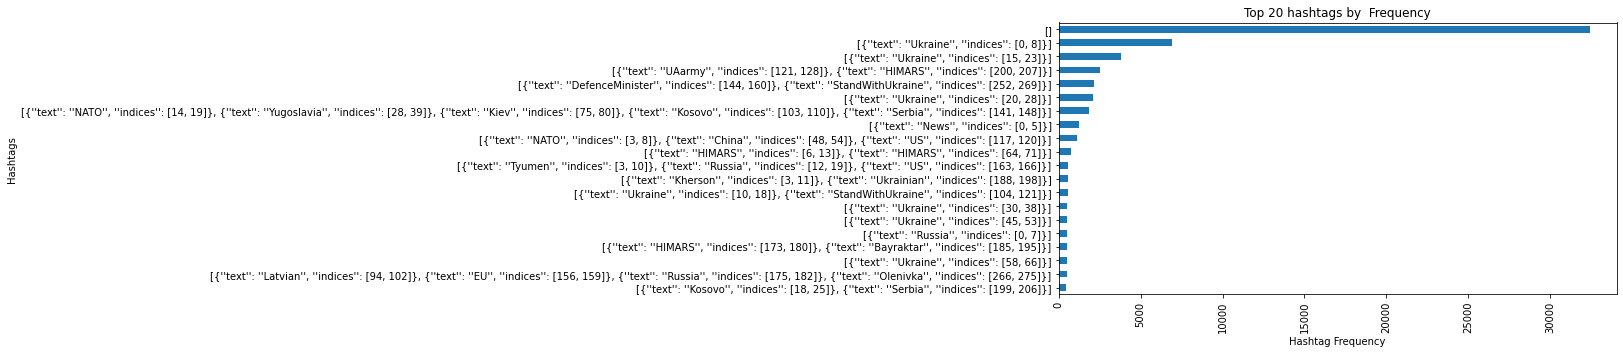

In [ ]:
# Find the top 20 hashtags by frequency
plt.figure(figsize=(10,5))
joined_data_df["hashtags"].value_counts().sort_values(ascending=True)[-20:].plot.barh();
plt.title("Top 20 hashtags by  Frequency")
plt.xlabel("Hashtag Frequency")
plt.ylabel("Hashtags")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()
plt.show()

In [ ]:
# Generate our categorical variable list
cat_var = joined_data_df.dtypes[joined_data_df.dtypes == "object"].index.tolist()

# Check the number of unique values in each column
joined_data_df[cat_var].nunique()

hashtags    152722
dtype: int64

In [ ]:
print (joined_data_df[cat_var])

                                                 hashtags
0       [{''text'': ''StandWithUkraine'', ''indices'':...
1       [{''text'': ''LePen'', ''indices'': [28, 34]},...
2       [{''text'': ''Mariupol'', ''indices'': [36, 45]}]
3       [{''text'': ''SlavaUkraini'', ''indices'': [30...
4        [{''text'': ''Ukraine'', ''indices'': [63, 71]}]
...                                                   ...
451695  [{''text'': ''KOSOVO'', ''indices'': [0, 7]}, ...
451696  [{''text'': ''StandWithUkraine'', ''indices'':...
451697  [{''text'': ''Tyumen'', ''indices'': [3, 10]},...
451698  [{''text'': ''Russia'', ''indices'': [9, 16]},...
451699  [{''text'': ''UkraineRussiaWar'', ''indices'':...

[451700 rows x 1 columns]


### There is too much hashtags for creating a OneHotEncoder instance

Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(joined_data_df[cat_var]))

Add the encoded variable names to the DataFrame
encode_df.columns = enc.get_feature_names(cat_var)
encode_df.head()

In [ ]:
# Drop the hashtags column
joined_data_df.drop("hashtags", axis=1, inplace=True)

In [ ]:
# Check data types
joined_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451700 entries, 0 to 451699
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   following        451700 non-null  int32  
 1   followers        451700 non-null  int32  
 2   totaltweets      451700 non-null  int32  
 3   tweetcreatedts   451700 non-null  float64
 4   is_retweet       451700 non-null  int64  
 5   is_quote_status  451700 non-null  int64  
 6   negative         83148 non-null   float64
 7   weight           449058 non-null  float64
 8   text_length      451680 non-null  float64
dtypes: float64(4), int32(3), int64(2)
memory usage: 25.8 MB


In [ ]:
# get the shape of the new DataFrame
print(f"{joined_data_df.shape[0]} rows and {joined_data_df.shape[1]} columns")

451700 rows and 9 columns


In [ ]:
negative_df = joined_data_df[['tweetcreatedts', 'negative']]
negative_df.head(5)

,tweetcreatedts,negative
0,20220422.0,0.010234
1,20220424.0,0.004823
2,20220424.0,0.018234
3,20220424.0,0.169791
4,20220422.0,0.156944


In [ ]:
# Drop the null rows
joined_data_df = joined_data_df.dropna()
print(f"{joined_data_df.shape[0]} rows and {joined_data_df.shape[1]} columns")

83147 rows and 9 columns


In [ ]:
negative_df = joined_data_df[['tweetcreatedts', 'negative']]
negative_df.head(5)

,tweetcreatedts,negative
0,20220422.0,0.010234
1,20220424.0,0.004823
2,20220424.0,0.018234
3,20220424.0,0.169791
4,20220422.0,0.156944


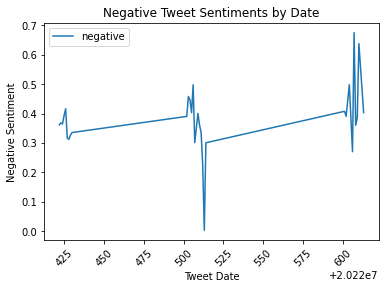

In [ ]:
#Get the plot of negative score by date of tweet
negative_by_date = negative_df.groupby([negative_df['tweetcreatedts']]).mean()

# plot bar graph of tweet count by date
negative_by_date.plot.line();

plt.title("Negative Tweet Sentiments by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Negative Sentiment")
plt.xticks(rotation=45)
plt.show()

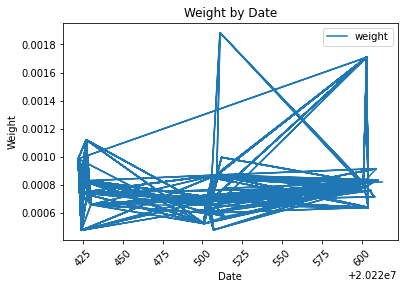

In [ ]:
#Get the plot of day weight by date
joined_data_df.plot.line(x='tweetcreatedts', y='weight');

plt.title("Weight by Date")
plt.xlabel("Date")
plt.ylabel("Weight")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

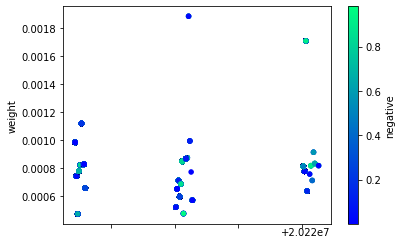

In [ ]:
# Plotting the data
joined_data_df.plot.scatter(x="tweetcreatedts", y="weight", c="negative", colormap="winter")

# Standartization Data

In [ ]:
# Create the StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
scaler.fit(joined_data_df)

# Scale the data
scaled_data = scaler.transform(joined_data_df)

# Create a DataFrame with the scaled data
transformed_scaled_data = pd.DataFrame(scaled_data, columns=joined_data_df.columns)
transformed_scaled_data.head(5)

,following,followers,totaltweets,tweetcreatedts,is_retweet,is_quote_status,negative,weight,text_length
0,-0.336036,-0.090515,-0.458301,-0.973757,0.70371,-0.324969,-1.117614,1.000514,-0.893686
1,0.022958,-0.076273,-0.549276,-0.939728,-1.42104,3.077219,-1.133617,-1.372268,-1.035154
2,0.040286,-0.089977,-0.418117,-0.939728,0.70371,-0.324969,-1.093953,-1.372268,-0.285373
3,-0.223725,-0.089102,-0.455128,-0.939728,0.70371,-0.324969,-0.645699,-1.372268,-1.898110
4,-0.300016,1.385954,5.642176,-0.973757,-1.42104,-0.324969,-0.683697,1.000514,-1.190769


# Deep Learning Model

Considering the output is a number of negative score of tweet emotions, as Activation function for the hidden layers we choosed ReLU, and as Activation function for the output layer we choosed Linear. For compiling model we used loss='mean_squared_error'.



In [ ]:
# Split our preprocessed data into our features and target arrays
y = transformed_scaled_data["negative"].values
X = transformed_scaled_data.drop(["negative"],1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Create scaler instance
X_scaler = skl.preprocessing.StandardScaler()

# Fit the scaler
X_scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
# Define the model - deep neural net
number_input_features = len(X_train[0])
hidden_nodes_layer1 = 8
hidden_nodes_layer2 = 5

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation='linear'))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 5)                 45        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 123
Trainable params: 123
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile the model
# tf.keras.losses.MeanAbsolutePercentageError(
#    reduction="auto", name="mean_absolute_percentage_error")
	
nn.compile(loss='mean_squared_error', optimizer="adam", metrics=["accuracy"])
#nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Fit the model to the training data
# Train the model
fit_model = nn.fit(X_train,y_train,epochs=100)
# fit_model = nn_model.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
1949/1949 [==============================] - 3s 1ms/step - loss: 1.0625 - accuracy: 0.0000e+00
Epoch 2/100
1949/1949 [==============================] - 3s 1ms/step - loss: 0.9942 - accuracy: 0.0000e+00
Epoch 3/100
1949/1949 [==============================] - 3s 1ms/step - loss: 0.9926 - accuracy: 0.0000e+00
Epoch 4/100
1949/1949 [==============================] - 3s 1ms/step - loss: 0.9923 - accuracy: 0.0000e+00
Epoch 5/100
1949/1949 [==============================] - 3s 1ms/step - loss: 0.9915 - accuracy: 0.0000e+00
Epoch 6/100
1949/1949 [==============================] - 3s 1ms/step - loss: 0.9910 - accuracy: 0.0000e+00
Epoch 7/100
1949/1949 [==============================] - 3s 1ms/step - loss: 0.9911 - accuracy: 0.0000e+00
Epoch 8/100
1949/1949 [==============================] - 3s 1ms/step - loss: 0.9910 - accuracy: 0.0000e+00
Epoch 9/100
1949/1949 [==============================] - 3s 1ms/step - loss: 0.9907 - accuracy: 0.0000e+00
Epoch 10/100
1949/1949 [=============

In [ ]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

650/650 - 1s - loss: 0.9946 - accuracy: 0.0000e+00 - 748ms/epoch - 1ms/step
Loss: 0.9946125745773315, Accuracy: 0.0


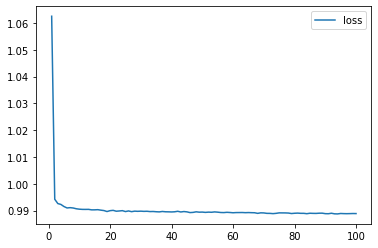

In [ ]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the loss
history_df.plot(y="loss")

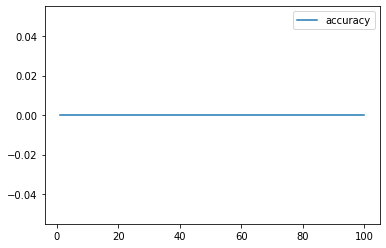

In [ ]:
# Plot the accuracy
history_df.plot(y="accuracy")